<a href="https://colab.research.google.com/github/nascimento-luciano/Artificial-Intelligence/blob/master/Mecanismos_de_aten%C3%A7%C3%A3o_e_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UNIVERSIDADE FEDERAL DO AGRESTE DE PERNAMBUCO**

**Redes Neurais [MÓDULO 02] - Mecanismos de Atenção - Prof. Dr. Luis F. Alves Pereira**

---
**Conteúdo:**

* Pooling de atenção
* Visualização de coeficientes de atenção
* Pooling de atenção Nadaraya-Watson
  - Pooling Nadaraya-Watson paramétrico
* Funções para nível de atenção
* Atenção de Bahdanau

---


#1. Pooling de atenção

O pooling de atenção proposto baseia-se na teoria clássica da psicologia em que percepções **não intencionais** e demandas **intencionais** do sujeito são processados em conjunto para definir o seu foco de atenção.

No modelo ilustrado a seguir, as percpções não intencionais são denominadas **keys**, as demandas intencionais são denominadas **queries**, e as entradas sensoriais que são objeto de foco da atenção são denominadas **values**.



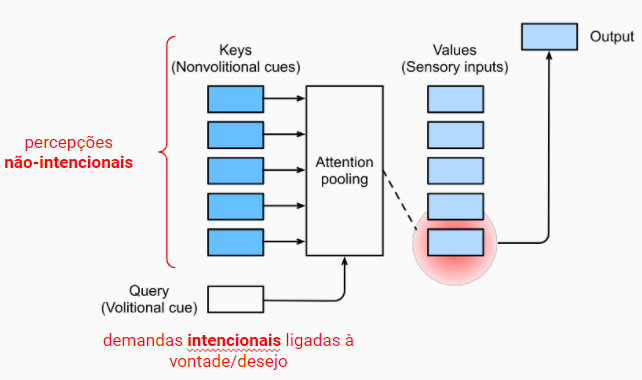

#2. Visualização de coeficientes de atenção

No código que segue implementamos função auxiliar para visualizar futuras iterações entre **queries** e **keys**. 

In [ ]:
!pip install matplotlib==2.2.3
!pip install -U d2l
import math
import tensorflow as tf
from d2l import tensorflow as d2l

  Using cached matplotlib-2.2.3-cp37-cp37m-manylinux1_x86_64.whl (12.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 2.2.3 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 2.2.3 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 2.2.3 which is incompatible.
arviz 0.11.4 requires matplotlib>=3.0, but you have matplotlib 2.2.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 2.2.3
    Uninstalling matplotlib-2.2.3:
      Successfully uninstalled matplotlib-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


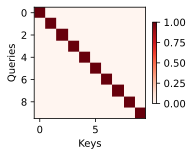

In [ ]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

attention_weights = tf.reshape(tf.eye(10), (1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

#3. Pooling de atenção Nadaraya-Watson

Para um determinado conjunto de treino $\{(x_1,y_1), (x_2,y_2), \cdots\}$, a regressão proposta por Nadaraya e Watson, em 1964, é composta pela soma ponderada das saídas $y_i$ em **função da distância** de $i$ para o ponto de interesse da regressão (i.e., **query**) $x$:


$f(x)= \sum_{i=1}^n\frac{K(x-x_i)}{\sum_{j=1}^n K(x-x_j)}y_i $

onde $K(\cdot,\cdot)$ é um kernel. Tal estimador pode ser visto como:

$f(x) = \sum_{i=1}^n \alpha(x,x_i)y_i$

A luz da teoria da atenção, $x$ pode ser entendida como **query**, $x_i$ como **key** e $y_i$ como **value**. Dessa forma, $\alpha(x,x_i)$ é um **coeficiente de atenção** associado ao value $y_i$ gerada a partir da interação entre a **query** $x$ e a **key** $x_i$.  

Por fim, note que todos os **coeficiente de atenção** $\alpha(x,x_i) = \frac{K(x-x_i)}{\sum_{j=1}^n K(x-x_j)}$ formam uma distribuição de probabilidade (valores não-negativos somando 1).

Ao utilizar o kernel gaussiano $K(u) = \frac{1}{\sqrt{2\pi}}exp\left(-\frac{u^2}{2}\right)$, temos:


$f(x)= \sum_{i=1}^n\alpha(x,x_i)y_i$

$f(x)= \sum_{i=1}^n\frac{exp\left(-\frac{1}{2}(x-x_i)^2\right)}{\sum_{j=1}^n exp\left(-\frac{1}{2}(x-x_j)^2\right)}y_i$

$f(x)=\sum_{i=1}^n softmax\left(-\frac{1}{2}(x-x_i)^2\right)y_i$

Para avaliar o pooling de atenção proposto, vamos criar a seguinte base de dados sintética:

In [ ]:
n_train = 50
x_train = tf.sort(tf.random.uniform(shape=(n_train,), maxval=5))

def f(x):
    return 2 * tf.sin(x) + x**0.8

y_train = f(x_train) + tf.random.normal((n_train,), 0.0, 0.5)  # Training outputs
x_test = tf.range(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples


E a seguinte funcionalidade para visualização:

In [ ]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

Aplicando agora o pooling de atenção Nadaraya-Watson com kernel Gaussiano como estimador para os pontos da base, temos:

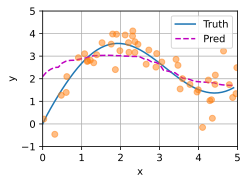

In [ ]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_train, axis=0)
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = tf.nn.softmax(-(X_repeat - tf.expand_dims(x_train, axis=1))**2/2, axis=1)
# Each element of `y_hat` is weighted average of values, where weights are attention weights
y_hat = tf.matmul(attention_weights, tf.expand_dims(y_train, axis=1))
plot_kernel_reg(y_hat)

Por fim, visualizamos que a atenção do modelo esteve em volta das **keys** mais próximas de cada **query** dada.

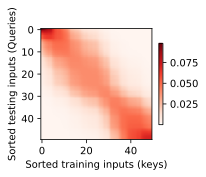

In [ ]:
d2l.show_heatmaps(tf.expand_dims(tf.expand_dims(attention_weights, axis=0), axis=0),
                  xlabel='Sorted training inputs (keys)',
                  ylabel='Sorted testing inputs (Queries)')

##3.1. Pooling Nadaraya-Watson paramétrico

Nesse exemplo, adicionamos um parâmetro treinável $\omega$ ao estimador descrito anteriormente. Assim temos:

$f(x)=\sum_{i=1}^n softmax\left(-\frac{1}{2}((x-x_i)\omega)^2\right)y_i$

In [ ]:
class NWKernelRegression(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable(initial_value=tf.random.uniform(shape=(1,)))

    def call(self, queries, keys, values, **kwargs):
        # For training queries are `x_train`. Keys are distance of taining data for each point. Values are `y_train`.
        # Shape of the output `queries` and `attention_weights`: (no. of queries, no. of key-value pairs)
        queries = tf.repeat(tf.expand_dims(queries, axis=1), repeats=keys.shape[1], axis=1)
        self.attention_weights = tf.nn.softmax(-((queries - keys) * self.w)**2 /2, axis =1)
        # Shape of `values`: (no. of queries, no. of key-value pairs)
        return tf.squeeze(tf.matmul(tf.expand_dims(self.attention_weights, axis=1), tf.expand_dims(values, axis=-1)))

Usamos os dados em *x_train* e *y_train* para treinar o modelo:

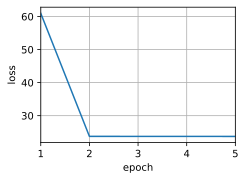

In [ ]:
# Shape of `X_tile`: (`n_train`, `n_train`), where each column contains the
# same training inputs
X_tile = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_train, axis=0)
# Shape of `Y_tile`: (`n_train`, `n_train`), where each column contains the
# same training outputs
Y_tile = tf.repeat(tf.expand_dims(y_train, axis=0), repeats=n_train, axis=0)
# Shape of `keys`: ('n_train', 'n_train' - 1)
keys = tf.reshape(X_tile[tf.cast(1 - tf.eye(n_train), dtype=tf.bool)], shape=(n_train, -1))
# Shape of `values`: ('n_train', 'n_train' - 1)
values = tf.reshape(Y_tile[tf.cast(1 - tf.eye(n_train), dtype=tf.bool)], shape=(n_train, -1))

net = NWKernelRegression()
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])


for epoch in range(5):
    with tf.GradientTape() as t:
        loss = loss_object(y_train, net(x_train, keys, values)) * len(y_train)
    grads = t.gradient(loss, net.trainable_variables)
    optimizer.apply_gradients(zip(grads, net.trainable_variables))
    print(f'epoch {epoch + 1}, loss {float(loss):.6f}')
    animator.add(epoch + 1, float(loss))


Podemos então visualizar a predição do modelo treinado para a base de treinamento:

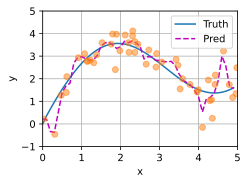

In [ ]:
# Shape of `keys`: (`n_test`, `n_train`), where each column contains the same
# training inputs (i.e., same keys)
keys = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_test, axis=0)
# Shape of `value`: (`n_test`, `n_train`)
values = tf.repeat(tf.expand_dims(y_train, axis=0), repeats=n_test, axis=0)
y_hat = net(x_test, keys, values)
plot_kernel_reg(y_hat)

Por fim, vamos observar os coeficientes de atenção do modelo Nadaraya-Watson paramétrico. Perceba que o foco de atenção está muito mais concentrado nas **keys** muito próximas a cada uma das **queries**.

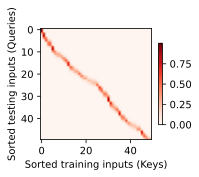

In [ ]:
d2l.show_heatmaps(tf.expand_dims(tf.expand_dims(net.attention_weights, axis=0), axis=0),
                  xlabel='Sorted training inputs (Keys)',
                  ylabel='Sorted testing inputs (Queries)')

#4. Funções para nível de atenção

A arquitetura que implementa o pooling de atenção discutido anteriormente é representado a seguir:

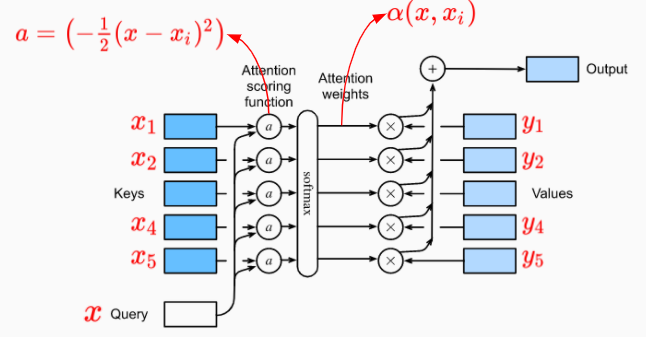

Vê-se claramente que a saída do pooling de atenção $f(\cdot)$ é dada pela soma das values ponderadas pelos coeficientes de atenção $\alpha(\cdot,\cdot)$ conforme explicitado a seguir: 

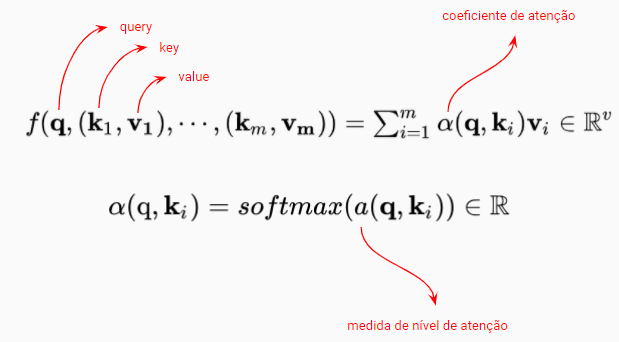

Além disso, o coeficiente de atenção é dado em função de função de nível de atenção $a(\cdot,\cdot)$. Percebe-se portanto que funções $a$ diferentes de $a = -\frac{1}{2}(\mathbf{q}-\mathbf{k_i})^2$ irão gerar poolings de atenção $f(\cdot)$ com novos comportamentos.

Uma alternativa para a medida de atenção $a(\cdot,\cdot)$ é dada pela **atenção aditiva** que segue:


$a(\mathbf{q},\mathbf{k}) = \mathbf{w}^T_v tanh(\mathbf{W}_{\frac{h}{2}q}\mathbf{q}+ \mathbf{W}_{\frac{h}{2}k}\mathbf{k}) \in \mathbb{R}, \mathbf{w}_v \in \mathbb{R}^h$

Através do código a seguir, demonstra-se a operação desse novo pooling de atenção.

In [ ]:
'''
"As we just mentioned, a softmax operation is used to output a probability distribution as attention weights. 
In some cases, not all the values should be fed into attention pooling. For instance, for efficient minibatch 
processing in Section 9.5, some text sequences are padded with special tokens that do not carry meaning. To get 
an attention pooling over only meaningful tokens as values, we can specify a valid sequence length (in number of tokens) 
to filter out those beyond this specified range when computing softmax. In this way, we can implement such a masked softmax
operation in the following masked_softmax function, where any value beyond the valid length is masked as zero."
'''

def masked_softmax(X, valid_lens):
    """Ignora dimensoes selecionadas para o calculo do softamax"""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return tf.nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        if len(valid_lens.shape) == 1:
            valid_lens = tf.repeat(valid_lens, repeats=shape[1])

        else:
            valid_lens = tf.reshape(valid_lens, shape=-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = d2l.sequence_mask(tf.reshape(X, shape=(-1, shape[-1])), valid_lens, value=-1e6)
        return tf.nn.softmax(tf.reshape(X, shape=shape), axis=-1)

class AdditiveAttention(tf.keras.layers.Layer):
    """Additive attention."""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = tf.keras.layers.Dense(num_hiddens, use_bias=False)
        self.W_q = tf.keras.layers.Dense(num_hiddens, use_bias=False)
        self.w_v = tf.keras.layers.Dense(1, use_bias=False)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, queries, keys, values, valid_lens, **kwargs):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = tf.expand_dims(queries, axis=2) + tf.expand_dims(keys, axis=1) # queries (`batch_size`, no. of queries, 1, `num_hiddens`) and keys  (`batch_size`, 1, no. of key-value pairs, `num_hiddens`)
        features = tf.nn.tanh(features)
        scores = tf.squeeze(self.w_v(features), axis=-1) #score/medida de arencao
        self.attention_weights = masked_softmax(scores, valid_lens) #apenas os coeficientes de atencao
        #valor final do pooling de atenção: values ponderados pelos coeficientes de atenção
        return tf.matmul(self.dropout(self.attention_weights, **kwargs), values) #values (`batch_size`, no. of key-value pairs, value dimension)


queries, keys = tf.random.normal(shape=(2, 1, 20)), tf.ones((2, 10, 2))
values = tf.repeat(tf.reshape(tf.range(40, dtype=tf.float32), shape=(1, 10, 4)), repeats=2, axis=0)

print("Shape Queries (Q):",queries.shape)
print("Shape Keys (K):",keys.shape)
print("Shape Values (V):", values.shape)


Shape Queries (Q): (2, 1, 20)
Shape Keys (K): (2, 10, 2)
Shape Values (V): (2, 10, 4)


A cardinalidade dos vetores $Q$, $K$, e $V$ pode ser compreendida pelo esquemático que segue

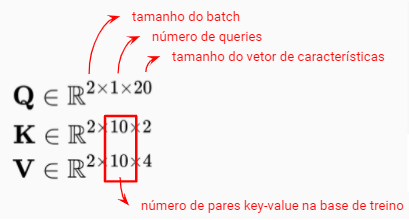

In [ ]:
valid_lens = tf.constant([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,dropout=0.1)
output = attention(queries, keys, values, valid_lens, training=False)

print("Shape output (f): ", output.shape)
print("Shape coeficientes de atencao (alfa): ", attention.attention_weights.shape)

Shape output (f):  (2, 1, 4)
Shape coeficientes de atencao (alfa):  (2, 1, 10)


A medida de **atenção aditiva** recebe este nome pois o processamento de **queries** e **keys** de diferentes tamanhos é possível "somando-se" suas dimensões em um estado escondido de tamanho fixo (que é atingido através de camadas dense).

Nos casos em que as **queries** e **keys** possuem o mesmo tamanho $d$, é possível utilizar uma medida de atenção baseada no produto interno normalizado entre $q$ e $k$; *i.e.*,  $a(\mathbf{q},\mathbf{t}) = \frac{\mathbf{q^Tk}}{\sqrt{d}}$.

O codigo exemplo implementa esta segunda medida de atenção:

In [ ]:
class DotProductAttention(tf.keras.layers.Layer):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def call(self, queries, keys, values, valid_lens, **kwargs):
        d = queries.shape[-1]
        scores = tf.matmul(queries, keys, transpose_b=True)/tf.math.sqrt(
            tf.cast(d, dtype=tf.float32))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return tf.matmul(self.dropout(self.attention_weights, **kwargs), values)

queries = tf.random.normal(shape=(2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention(queries, keys, values, valid_lens, training=False)

print("Shape Queries (Q):",queries.shape)
print("Shape Keys (K):",keys.shape)
print("Shape Values (V):", values.shape)
print("Shape output (f): ", output.shape)
print("Shape coeficientes de atencao (alfa): ", attention.attention_weights.shape)

Shape Queries (Q): (2, 1, 2)
Shape Keys (K): (2, 10, 2)
Shape Values (V): (2, 10, 4)
Shape output (f):  (2, 1, 4)
Shape coeficientes de atencao (alfa):  (2, 1, 10)


#5. Atenção de Bahdanau



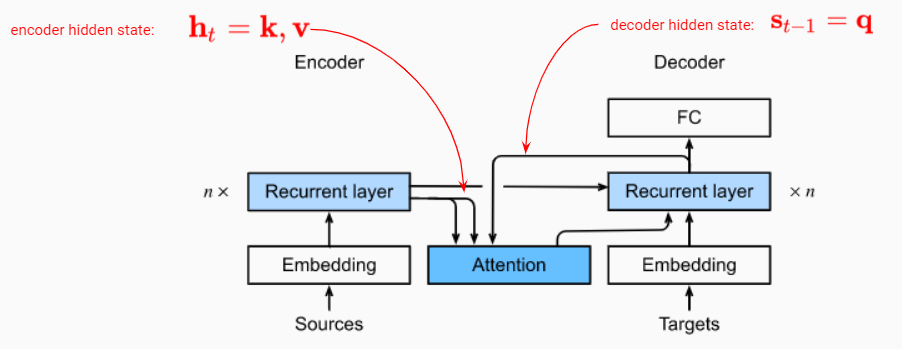

In [ ]:
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(*kwargs)
        # Embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(
            [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout) for _ in range(num_layers)]),
             return_sequences=True, return_state=True)

    def call(self, X, *args, **kwargs):
        # The input `X` shape: (`batch_size`, `num_steps`)
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        output = self.rnn(X, **kwargs)
        state = output[1:]
        return output[0], state

class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens,
                                               num_hiddens, dropout)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(
            [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
             for _ in range(num_layers)]),
                                      return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # Shape of `outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        outputs, hidden_state = enc_outputs
        return (outputs, hidden_state, enc_valid_lens)

    def call(self, X, state, **kwargs):
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output `X`: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X) # Input `X` has shape: (`batch_size`, `num_steps`)
        X = tf.transpose(X, perm=(1, 0, 2))
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of `query`: (`batch_size`, 1, `num_hiddens`)
            query = tf.expand_dims(hidden_state[-1], axis=1)
            # Shape of `context`: (`batch_size, 1, `num_hiddens`)
            context = self.attention(query, enc_outputs, enc_outputs,
                                     enc_valid_lens, **kwargs)
            # Concatenate on the feature dimension
            x = tf.concat((context, tf.expand_dims(x, axis=1)), axis=-1)
            out = self.rnn(x, hidden_state, **kwargs)
            hidden_state = out[1:]
            outputs.append(out[0])
            self._attention_weights.append(self.attention.attention_weights)
        # After fully-connected layer transformation, shape of `outputs`:
        # (`batch_size`, `num_steps`, `vocab_size`)
        outputs = self.dense(tf.concat(outputs, axis=1))
        return outputs, [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.026, 774.0 tokens/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7f1d7056f730>


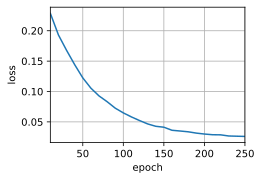

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .', 'I am student .']

for eng in engs:
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, True)
    print(f'{eng} => {translation}, ')

go . => va !, 
i lost . => j'ai perdu ., 
he's calm . => il est mouillé ., 
i'm home . => je suis chez moi ., 
I am student . => je suis <unk> ., 


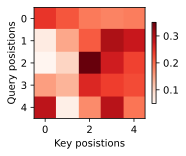

In [ ]:
attention_weights = tf.reshape(tf.concat([step[0][0][0] for step in dec_attention_weight_seq], 0), (1, 1, -1, num_steps))

d2l.show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1], xlabel='Key posistions', ylabel='Query posistions')